# Implement convolutions in a whole net

In [ ]:
%load_ext pycodestyle_magic
%flake8_on

ModuleNotFoundError: ignored

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torchvision.datasets import MNIST
import torch.nn.functional as F

# Get Data

In [2]:
# Get the data using pytorch MNIST function
trainset = MNIST('../../', download=True, train=True)
testset = MNIST('../../', download=True, train=False)

# Store the labels
y_trainset = trainset.targets
y_testset = testset.targets

# reshape and pass to float32
train = trainset.data.reshape(60000, -1)
test = testset.data.reshape(10000, -1)
trainset = train.to(torch.float32)
testset = test.to(torch.float32)

# Normalize
m, std = trainset.mean(), trainset.std()
trainset = (trainset - m) / std
testset = (testset - m) / std

print(trainset.mean(), trainset.std())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../../MNIST/raw/train-images-idx3-ubyte.gz to ../../MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../../MNIST/raw/train-labels-idx1-ubyte.gz to ../../MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../../MNIST/raw/t10k-images-idx3-ubyte.gz to ../../MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../../MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


tensor(1.8892e-08) tensor(1.)


# Define useful classes

In [ ]:
class Dataset():
    # A convenience class to have all your data stored at the same place
    # common practice
    def __init__(self, x, y): self.x, self.y = x, y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i], self.y[i] 

In [ ]:
class DataLoader():
    # helps us do minibatch training
    def __init__(self, data, bs):
        self.data, self.bs = data, bs

    def __iter__(self):
        for i in range(0, len(self.data), self.bs):
            yield self.data[i:i+self.bs]

In [ ]:
class Optimizer():
    # is used to get rid of code inside the training loop
    def __init__(self, parameters, lr=0.4):
        self.parameters, self.lr = list(parameters), lr

    def step(self):
        with torch.no_grad():
            for p in self.parameters:
                p -= p.grad * self.lr

    def zero_grad(self):
        for p in self.parameters:
            p.grad.zero_()

In [ ]:
def accuracy(output, target):
    return (torch.argmax(output, dim=1) == target).float().mean()

In [ ]:
# explain accuracy
my_output = torch.randn(64, 10)
# my_output
torch.argmax(my_output)  # only one number
torch.argmax(my_output, dim=1)  # 64 numbers (one pred for each image)

tensor([3, 2, 1, 3, 1, 7, 3, 0, 1, 7, 0, 6, 1, 8, 7, 8, 7, 6, 6, 3, 6, 5, 0, 5,
        4, 1, 0, 1, 4, 8, 7, 6, 7, 5, 2, 6, 5, 4, 8, 9, 7, 5, 0, 0, 0, 0, 0, 6,
        7, 1, 6, 1, 1, 9, 8, 5, 1, 0, 5, 8, 3, 1, 9, 8])

In [ ]:
EPOCHS = 5
lr = 0.3
bs = 64
loss_func = F.cross_entropy

# here we will later download and assign pre-trained models
learner = nn.Sequential(
    nn.Linear(784, 250),
    nn.ReLU(),
    nn.Linear(250, 100),
    nn.ReLU(),
    nn.Linear(100, 10)
)

# Your nn.Sequential has a .parameters() attribute !
# so the Optimizer find alone all the tensors that require gradients ! 
opt = Optimizer(learner.parameters(), lr=lr)

my_data = Dataset(trainset, y_trainset)
train_dataloader = DataLoader(my_data, bs)

In [ ]:
for i in range(EPOCHS):
    for xb, yb in train_dataloader:
        output = learner(xb)
        loss = loss_func(output, yb)
        # backward pass:
        loss.backward()
        
        # we've removed all the mess into opt: 
        opt.step() #replaces a.weight -= a.weight.grad * lr
        opt.zero_grad()
    print(loss)

tensor(0.0257, grad_fn=<NllLossBackward>)
tensor(0.0063, grad_fn=<NllLossBackward>)
tensor(0.0013, grad_fn=<NllLossBackward>)
tensor(0.0027, grad_fn=<NllLossBackward>)
tensor(0.0004, grad_fn=<NllLossBackward>)


In [ ]:
# careful, we asked for a 64 batch size, but the last batch is 32 
xb.shape

torch.Size([32, 784])

In [ ]:
# 937 batches of 64, and a half batch of 64, hence 32 
60000 / 64 

937.5

In [ ]:
60000 % 64

32

# Adding Validation

In [ ]:
train, valid = trainset[0:50000, :], trainset[50000:, :]
y_train, y_valid = y_trainset[0:50000], y_trainset[50000:]

We'll now start using Pytorch's DataLoader because it also has a random sampler

In [ ]:
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [ ]:
train_dl = DataLoader(Dataset(train, y_train), batch_size=64, shuffle=True)
valid_dl = DataLoader(Dataset(valid, y_valid), 64)

In [ ]:
for epoch in range(EPOCHS):
    # learner.train() puts the model in train mode (it calculates gradients)
    learner.train()
    for xb, yb in train_dl:
        output = learner(xb)
        loss = loss_func(output, yb)
        # backward pass:
        loss.backward()
        
        # we've removed all the mess into opt: 
        opt.step() #replaces a.weight -= a.weight.grad * lr
        opt.zero_grad()

    # learner.eval() puts the model in eval mode (it calculates gradients)
    learner.eval()
    with torch.no_grad():
        total_loss, total_acc = 0., 0.
        for xb, yb in valid_dl:
            pred = learner(xb)
            total_loss += loss_func(pred, yb)
            total_acc += accuracy(pred, yb)
            
        # we calculate above to have metrics during training, but note we are
        # NOT DOING back propagation
        n_entries = len(valid_dl)
        print('epoch', epoch,
              'loss:', (total_loss/n_entries).item(),
              'accuracy:', (total_acc/n_entries).item()
              )

epoch 0 loss: 0.06000960245728493 accuracy: 0.9791003465652466
epoch 1 loss: 0.04035491868853569 accuracy: 0.987957775592804
epoch 2 loss: 0.034348633140325546 accuracy: 0.9898487329483032
epoch 3 loss: 0.0317419208586216 accuracy: 0.9912420511245728
epoch 4 loss: 0.0350671261548996 accuracy: 0.990545392036438


# Adding convolutions

Now adding convolutions is just a matter of changing the sequence of layers in nn.Sequential

In [ ]:
# Use Jupyter Notebook shortcuts to access the doc and see how to use Conv2d
# ??nn.Conv2d

In [ ]:
xb.shape

torch.Size([16, 784])

In [ ]:
# We can basically replace the nn.Linear with this:
my_layer = nn.Conv2d(in_channels=1, out_channels=9, kernel_size=3, padding=1)

# PAY ATTENTION HERE
# Except nn.Conv2d takes input of shape N * Channels * Height * Width
# (as seen in the doc if you uncomment above)
# and we had no channels so far (MNIST isn't RVB), so we add an extra channel
my_layer(xb.reshape(16, 1, 28, 28)).shape

torch.Size([16, 9, 28, 28])

In [ ]:
# We also need to flatten out the output of the successive convolutions
# before we pass it to a nn.Linear()
# we add a Lambda layer (pretty much like a lambda function) to do that


class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def flatten(x):
    return x.view(x.shape[0], -1)

# we can also use that Lambda class to resize the data as in the above cell
def mnist_resize(x): return x.view(-1, 1, 28, 28) 

In [ ]:
EPOCHS = 6
lr = 0.4
bs = 64
loss_func = F.cross_entropy

# I created the network for you and we'll follow 
# the code together ;) 
learner = nn.Sequential(
    Lambda(mnist_resize),  # we can do the reshape here
    nn.Conv2d(in_channels=1, out_channels=8,
              kernel_size=3, stride=1, padding=1),  # bs*8*28*28
    nn.ReLU(),
    nn.Conv2d(8, 16, 3, 2, 1),  # bs*16*14*14
    nn.ReLU(),
    nn.Conv2d(16, 32, 3, 2, 1),  # bs * 32 * 7 * 7
    nn.ReLU(),
    nn.Conv2d(32, 64, 3, 2, 1),  # bs * 64 * 4 * 4
    nn.ReLU(),
    nn.Conv2d(64, 64, 3, 2, 1),  # bs * 64 * 2 * 2
    nn.AdaptiveAvgPool2d(1),
    Lambda(flatten),
    nn.Linear(64, 10)
)

opt = Optimizer(learner.parameters(), lr=lr)

In [ ]:
# A cool thing is that the train loop doesn't need to change
for epoch in range(EPOCHS):
    # learner.train() puts the model in train mode (it calculates gradients)
    learner.train()
    
    for xb, yb in train_dl:
        # again, practice 
        output = learner(xb)
        loss = loss_func(output, yb)
        # backward pass:
        loss.backward()
        
        # we've removed all the mess into opt: 
        opt.step() #replaces a.weight -= a.weight.grad * lr
        opt.zero_grad()

    # put your learner in eval mode 
    
    with torch.no_grad():
        total_loss, total_acc = 0., 0.
        for xb, yb in valid_dl:
            pred = learner(xb)
            total_loss += loss_func(pred, yb)
            total_acc += accuracy(pred, yb)
        n_entries = len(valid_dl)
        print('epoch', epoch,
              'loss:', (total_loss/n_entries).item(),
              'accuracy:', (total_acc/n_entries).item()
              )

epoch 0 loss: 0.15606139600276947 accuracy: 0.9513335824012756
epoch 1 loss: 0.0642513856291771 accuracy: 0.9818869233131409
epoch 2 loss: 0.058290936052799225 accuracy: 0.984375
epoch 3 loss: 0.0683569684624672 accuracy: 0.9797969460487366
epoch 4 loss: 0.05379178002476692 accuracy: 0.9839769005775452
epoch 5 loss: 0.13220947980880737 accuracy: 0.9632762670516968


So, we added convolutions, but two problems arose:

* the training isn't very smooth. We'll need to add some regularization
* the training is way slower than before. We'll need to start using the GPU

### Sanity check

In [ ]:
import matplotlib.pyplot as plt

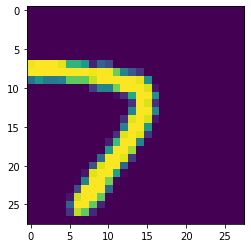

In [ ]:
seven = testset.data[17].reshape(28, 28)
cut_seven = seven[:, 5:22]
shifted_seven = torch.zeros(28, 28)
shifted_seven[:, :] = -0.4241
shifted_seven[:, 0:17] = cut_seven
plt.imshow(shifted_seven.numpy())

In [ ]:
learner(seven).argmax(dim=-1), learner(shifted_seven).argmax(dim=-1)

(tensor([7]), tensor([7]))

# In practice

In [ ]:
from torchvision.models.resnet import resnet18

In [ ]:
resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Next: FastAI